In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
from plotly import graph_objs as go
from __future__ import division

%matplotlib inline

plt.style.use('default')

sns.set(style='whitegrid')

# Análisis de Eventos basado en usuarios que visitan el sitio y realizan una conversion en el mismo.

La idea de este notebook es investigar un poco sobre el rendimiento de la página de la empresa.

Lo que nos interesa ver es:

1. De los usuarios que llegan a la instancia de check-out, ¿Cuántos realizan una conversion?

2. ¿Cómo evolucionan en el tiempo las compras, checkouts y vistas de producto?

3. Considerando los usuarios que llegan al sitio a través de una publicidad, ¿Cuántos realizan conversiones?

In [2]:
df = pd.read_csv('events.csv', low_memory=False)

In [3]:
# TODO: Cargar usuarios con conversion y checkout, mostrar que el top tiene conversions sin checkouts
# y plantear la razón posible para esto (compras fuera del sitio),
# a modo de introducción al análisis y filtro que haremos para el mismo.

## De los usuarios que llegan a la instancia de check-out, ¿Cuántos realizan una conversion?

Vamos a obtener a todos los usuarios que tienen conversiones, para luego obtener a aquellos que también
tienen check-outs.

In [4]:
conversiones = df.loc[df['event'] == 'conversion', ['event', 'person', 'sku', 'model']].copy()
conversiones_sin_us_dup = conversiones.drop_duplicates(subset='person')
usuarios_con_conversiones = set(conversiones_sin_us_dup['person'])
len(usuarios_con_conversiones)

716

Ahora obtenemos los que también tienen check-outs.

In [5]:
usuarios_con_checkout_conversion = df.loc[(df['event'] == 'checkout') &
                                          df['person'].isin(usuarios_con_conversiones), ['person']]
usuarios_con_checkout_conversion.drop_duplicates(subset='person', inplace=True)
usuarios_con_checkout_conversion = set(usuarios_con_checkout_conversion['person'])

Procedemos a quedarnos con aquellos que compraron en el sitio de la empresa, nos basamos en que
exista un check-out previo a una conversion, sobre el mismo SKU.

In [6]:
usuarios_filtrados = df.loc[(df['person'].isin(usuarios_con_checkout_conversion)) &
            (df['event'].isin(['checkout', 'conversion'])), ['timestamp', 'event', 'person', 'sku', 'model']]
usuarios_filtrados.drop_duplicates(subset=['event','person'], inplace=True)
usuarios_filtrados = usuarios_filtrados[usuarios_filtrados.duplicated(subset=['person', 'sku'], keep=False)]
usuarios_filtrados.describe().T

,count,unique,top,freq
timestamp,762,762,2018-03-06 02:13:27,1
event,762,2,conversion,381
person,762,381,a2eb4a99,2
sku,762,271,6371.0,14
model,762,87,iPhone 5s,60


Notemos que algunos usuarios tienen invertido el orden check-out/conversion. Por lo que no sabemos si
la conversion fue realizada en el sitio o fuera del mismo (y presentan una diferencia de tiempo importante
entre ambos eventos)

In [7]:
usuarios_filtrados.head()

,timestamp,event,person,sku,model
2547,2018-06-10 14:37:50,conversion,00fdbb4b,3348.0,Samsung Galaxy S6 Flat
2555,2018-06-11 01:47:34,checkout,00fdbb4b,3348.0,Samsung Galaxy S6 Flat
4244,2018-03-16 13:41:36,checkout,0146a9df,2694.0,iPhone 5s
4245,2018-03-16 13:50:25,conversion,0146a9df,2694.0,iPhone 5s
6984,2018-02-09 21:54:43,checkout,01db2fe6,6357.0,Samsung Galaxy J5


Obtenemos una lista de usuarios sin duplicados.

In [8]:
usuarios = set(usuarios_filtrados.drop_duplicates(subset='person')['person'])
len(usuarios)

381

Ahora nos quedamos con aquellos que tienen conversions pero no tienen check-outs relacionados a estas.

In [9]:
us_conversion_sin_checkout = set([x for x in usuarios_con_conversiones if x not in usuarios])
len(us_conversion_sin_checkout)

335

Nos quedaría quitar a aquellos usuarios que tienen invertido el orden en el que se realiza una conversion
desde el sitio de la empresa. Es decir, aquellos que primero presenten una conversion y luego un check-out.

In [10]:
usuarios_conflictivos = set()
row_iterator = usuarios_filtrados.iterrows()
for i, row in row_iterator:
    next_row = next(row_iterator)[1]
    if (row['event'] + next_row['event']) == "conversioncheckout":
        usuarios_conflictivos.add(row['person'])
        continue
    if ((pd.to_datetime(next_row['timestamp']) - pd.to_datetime(row['timestamp'])).seconds / 3600.0 > 1):
        usuarios_conflictivos.add(row['person'])
us_conversion_sin_checkout = us_conversion_sin_checkout.union(usuarios_conflictivos)

In [11]:
df_filtrado = df.loc[(~df['person'].isin(us_conversion_sin_checkout))].copy()

In [12]:
funnel = df_filtrado.loc[df['event'].isin(['visited site', 'checkout', 'conversion']), ['person','event']]

In [13]:
funnel_vc = funnel['event'].value_counts()
funnel_vc

visited site    79239
checkout        31621
conversion        393
Name: event, dtype: int64

Finalmente tenemos los datos filtrados para realizar un diagrama de Sankey, mostrando el flujo de conversiones del sitio.

In [ ]:
import plotly.plotly as py
import plotly

data = dict(
    type='sankey',
    arrangement="freeform",
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = ["visited site", "checkout", "conversion","no hacen checkout","no hacen conversion"],
      color = ["blue", "blue", "blue","red","red"]
    ),
    link = dict(
      source = [0,0,1,1],
      target = [3,1,2,4],
      value = [(79239-31621),31621,393,(31621-393)] #alterar aca los valores
  ))

layout =  dict(
    title = "Diagrama sankey del funnel",
    font = dict(
      size = 10
    )
)

plotly.offline.init_notebook_mode(connected=True)
fig = dict(data=[data], layout=layout)
plotly.offline.iplot(fig)

## Observaciones

Finalmente podemos ver que un ~1,38% de los usuarios que llegan a la etapa de checkout, confirman un pago realizando una conversion (el goal de la empresa)

# Evolución en el tiempo de checkouts, compras y vistas de productos, en el sitio.

Aprovechando que filtramos a los usuarios que no realizan sus compras en el sitio de Trocafone, vamos a revisar cómo fue la evolución en el tiempo de compras, checkouts y vistas de productos en el sitio.

En particular nos interesaría encontrar picos importantes de tráfico, o bien ver si se mantuvieron estables estas tres categorías.

In [14]:
def graficar_lineplot(titulo, data):
    g = sns.lineplot(x=data.index, y=data.values)
    g.set(xticklabels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'])
    g.set_title(titulo, fontsize=18)
    g.set_xlabel('Mes', fontsize=16)
    g.set_ylabel('Frecuencia', fontsize=16)
    return g

In [15]:
df_filtrado['timestamp'] = pd.to_datetime(df_filtrado['timestamp']).dt.date

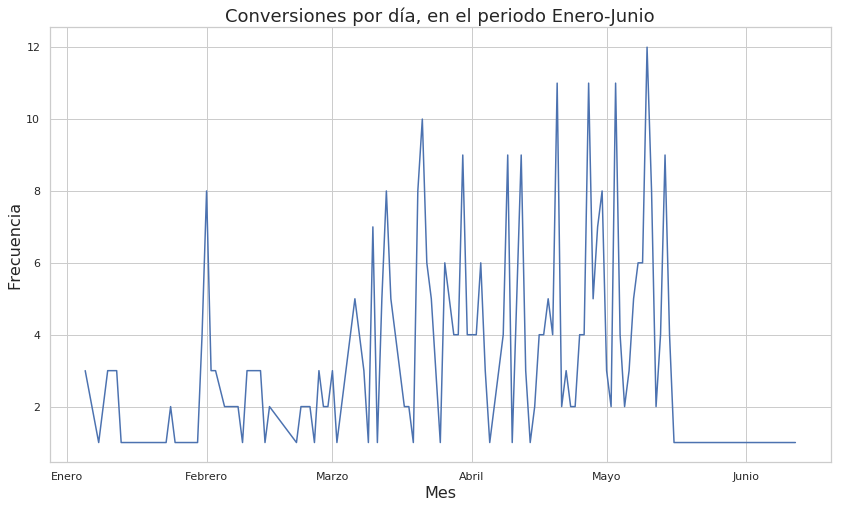

In [16]:
ts_conversion = df_filtrado.loc[df_filtrado['event'] == 'conversion'].sort_values(by='timestamp')
ts_vc = ts_conversion['timestamp'].value_counts()
plt.figure(figsize=(14,8))
g = graficar_lineplot('Conversiones por día, en el periodo Enero-Junio', ts_vc)
plt.show()

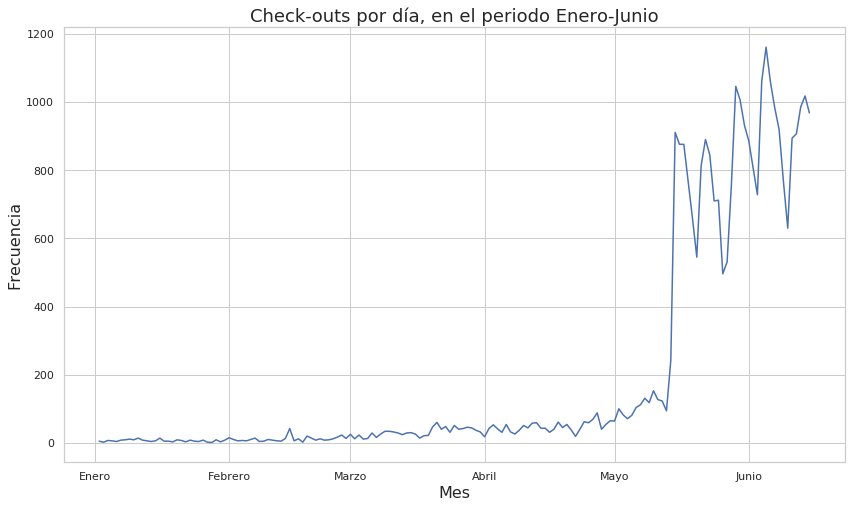

In [17]:
ts_checkout = df_filtrado.loc[df_filtrado['event'] == 'checkout'].sort_values(by='timestamp')
ts_vc = ts_checkout['timestamp'].value_counts()
plt.figure(figsize=(14,8))
g = graficar_lineplot('Check-outs por día, en el periodo Enero-Junio', ts_vc)
plt.show()

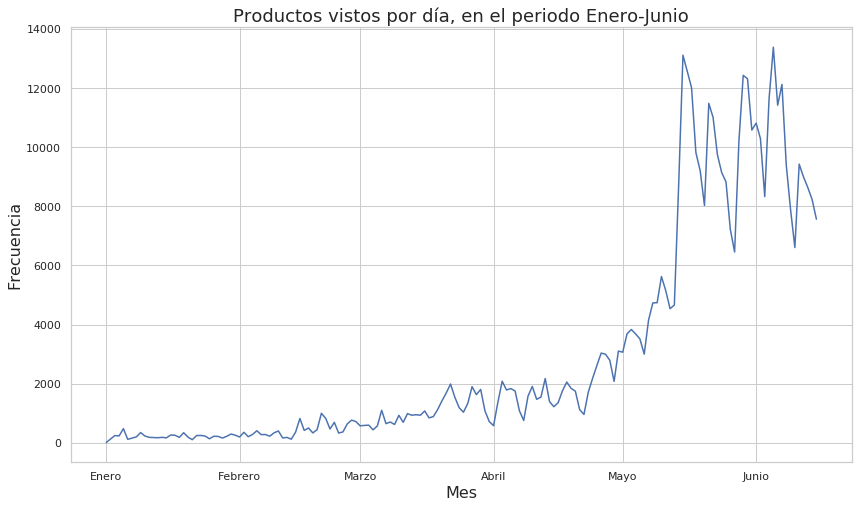

In [18]:
ts_viewed_product = df_filtrado.loc[df_filtrado['event'] == 'viewed product'].sort_values(by='timestamp')
ts_vc = ts_viewed_product['timestamp'].value_counts()
plt.figure(figsize=(14,8))
g = graficar_lineplot('Productos vistos por día, en el periodo Enero-Junio', ts_vc)
plt.show()

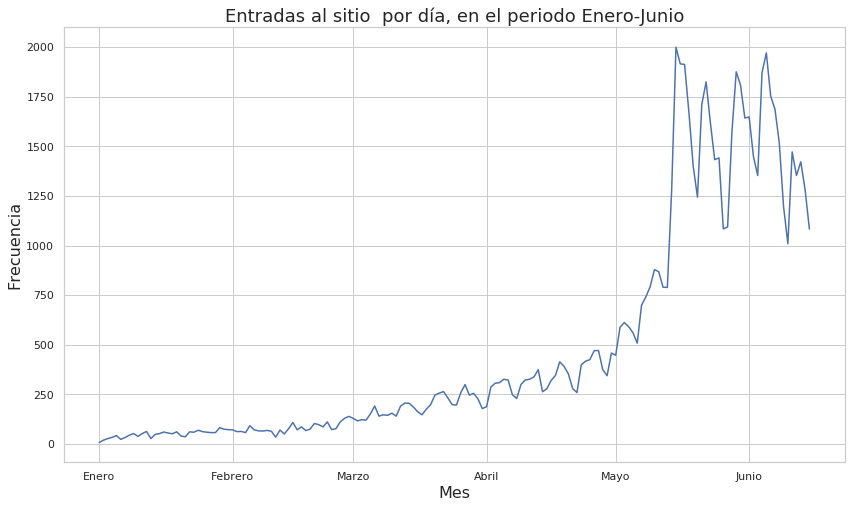

In [19]:
ts_viewed_product = df_filtrado.loc[df_filtrado['event'] == 'visited site'].sort_values(by='timestamp')
ts_vc = ts_viewed_product['timestamp'].value_counts()
plt.figure(figsize=(14,8))
g = graficar_lineplot('Entradas al sitio  por día, en el periodo Enero-Junio', ts_vc)
plt.show()

# Observaciones

Podemos notar un fuerte incremento en la actividad del sitio a partir de la mitad de Mayo hasta el final de los datos que poseemos (Junio). Curiosamente, el movimiento de checkouts y productos vistos es similar, aunque en distinta escala.
Esto podría deberse a algún tipo de _sale event_ o campaña de ads. Analizareoms esta posibilidad a continuación.

En cuanto a las conversiones, también notamos mayor actividad durante el mes de Mayo, en particular tenemos tres picos importantes a comparación del resto de los meses.